Processing category: 1%
Skipping non-image file: .DS_Store
Processing category: 1.5%
Skipping non-image file: .DS_Store
Processing category: 2%
Skipping non-image file: .DS_Store
Total images processed: 180
Image dataset shape: (180, 224, 299, 3)
Target dataset shape: (180,)


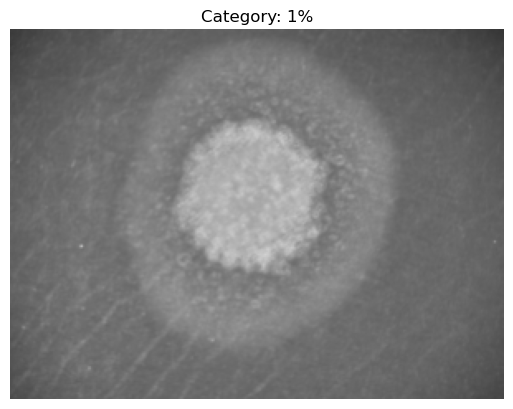

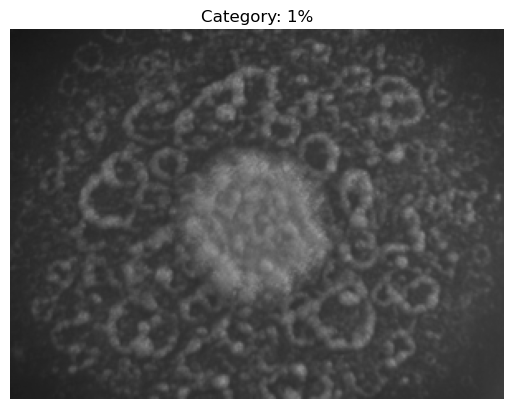

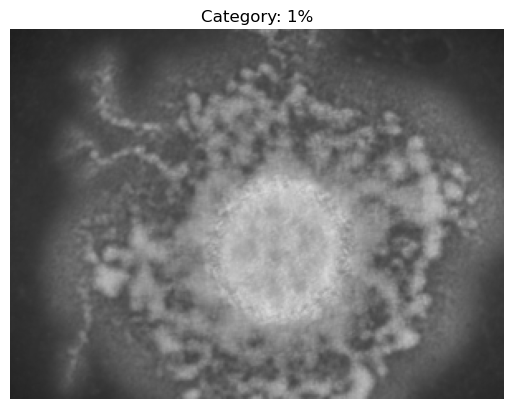

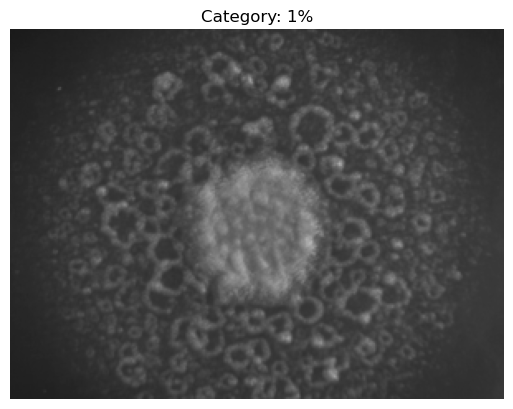

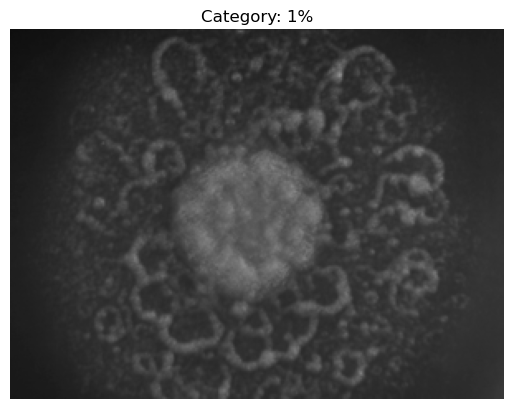

In [87]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Use current working directory for data
DataDirectory = os.getcwd()
Categories = ["1%", "1.5%", "2%"]

# Function to normalize brightness and crop the center of the image
def normalize_and_crop_center(img, center_percentage=0.75):
    """
    Normalize brightness and crop the center of the image.

    Args:
        img: Input image.
        center_percentage: Percentage of the image to retain.

    Returns:
        Preprocessed image resized to (224, 299).
    """
    if len(img.shape) == 3:
        img = rgb2gray(img)  # Convert to grayscale if the image has multiple channels
    img = (img * 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
    h, w = img.shape[:2]
    crop_h = int(h * center_percentage)
    crop_w = int(w * center_percentage)
    start_x = (w - crop_w) // 2
    start_y = (h - crop_h) // 2
    # Crop and resize the central region
    cropped_img = img[start_y:start_y + crop_h, start_x:start_x + crop_w]
    cropped_resized_img = resize(cropped_img, (224, 299), anti_aliasing=True)
    cropped_resized_img = np.stack([cropped_resized_img] * 3, axis=-1)  # Convert to 3 channels for the model
    return cropped_resized_img

# Initialize lists to store images and their labels
images, target = [], []

# Iterate through categories and process images
for category in Categories:
    print(f"Processing category: {category}")
    target_class = Categories.index(category)
    path = os.path.join(DataDirectory, category)
    
    for img_file in os.listdir(path):
        # Skip non-image files like .DS_Store
        if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif', '.tif')):
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip to the next file
        
        try:
            img_path = os.path.join(path, img_file)
            img_array = rgb2gray(imread(img_path))  # Read and convert to grayscale
            img_normalized_cropped = normalize_and_crop_center(img_array, center_percentage=0.75)
            images.append(img_normalized_cropped)
            target.append(target_class)
        except Exception as e:
            print(f"Error processing file {img_file}: {e}")
            continue

# Convert lists to numpy arrays
images = np.array(images)
target = np.array(target)

print(f"Total images processed: {len(images)}")
print(f"Image dataset shape: {images.shape}")
print(f"Target dataset shape: {target.shape}")

# Display a few images
for i in range(min(5, len(images))):  # Display up to 5 images
    plt.figure()
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Category: {Categories[target[i]]}")
    plt.axis('off')
    plt.show()


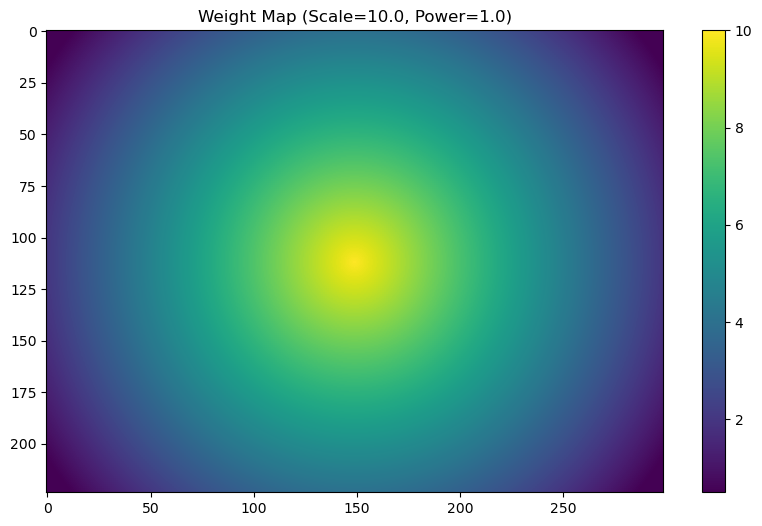

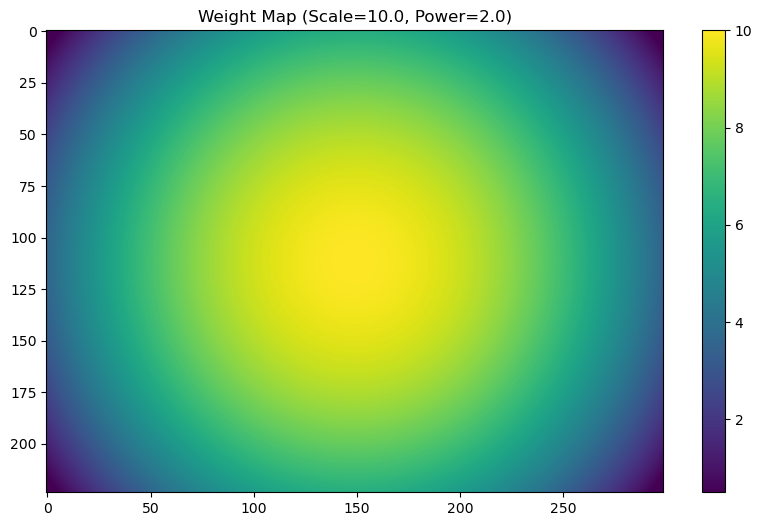

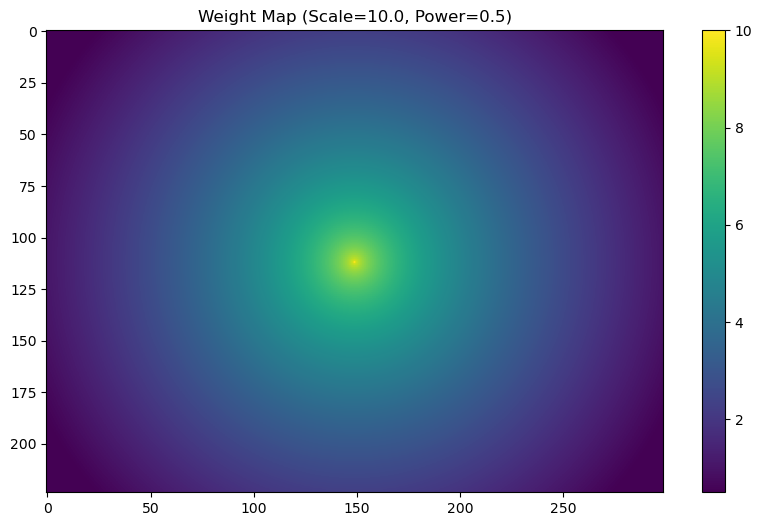

In [88]:
def visualize_weight_map(img_height=224, img_width=299, scale=10.0, power=1.0):
    center_x, center_y = img_width // 2, img_height // 2
    y_coords, x_coords = np.meshgrid(np.arange(img_height), np.arange(img_width), indexing="ij")
    distances = np.sqrt((y_coords - center_y) ** 2 + (x_coords - center_x) ** 2)
    max_distance = np.sqrt(center_x ** 2 + center_y ** 2)
    
    # Compute weight map
    weight_map = scale * (1 - (distances / max_distance) ** power)
    weight_map = np.clip(weight_map, 0.5, scale)

    # Visualize the weight map
    plt.figure(figsize=(10, 6))
    plt.imshow(weight_map, cmap="viridis")
    plt.colorbar()
    plt.title(f"Weight Map (Scale={scale}, Power={power})")
    plt.show()

# Example visualizations
visualize_weight_map(scale=10.0, power=1.0)  # 1.0 Linear increase
visualize_weight_map(scale=10.0, power=2.0)  # 2.0 Quadratic increase
visualize_weight_map(scale=10.0, power=0.5)  # 0.5 Slower increase

In [89]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, target, shuffle=True, test_size=0.5, random_state=109, stratify=target)
print("Training set label distribution:", np.bincount(y_train))
print("Test set label distribution:", np.bincount(y_test))

# Define DELU activation function
class DELU(tf.keras.layers.Layer):
    """
    A custom activation function DELU (Dynamic Exponential Linear Unit).
    """
    def __init__(self, **kwargs):
        super(DELU, self).__init__(**kwargs)

    def call(self, inputs):
        # Compute a dynamic scaling factor (alpha) based on the input's average absolute value
        alpha = tf.reduce_mean(tf.abs(inputs), axis=-1, keepdims=True)
        # Apply DELU: use linear activation for positive inputs and scaled exponential activation for negatives
        return tf.where(inputs > 0, inputs, alpha * (tf.exp(inputs) - 1))

Training set label distribution: [30 30 30]
Test set label distribution: [30 30 30]


In [90]:
# Define a CNN model for classification
# Define activation functions
activation_functions = ['delu']

# Train and evaluate a CNN model for each activation function
results = []
for activation in activation_functions:
    print(f"\nTraining model with activation function: {activation}")

    # Use the custom DELU function if specified
    if activation == 'delu':
        activation_layer = DELU()
    else:
        activation_layer = activation

    # Define the CNN model. 
    model = Sequential([
        Input(shape=(224, 299, 3)),
        Conv2D(32, (3, 3), activation=activation_layer),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation_layer),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation=activation_layer),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation=activation_layer),
        Dense(len(Categories), activation='softmax')
    ])


'''
model = Sequential([
    Input(shape=(224, 299, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(Categories), activation='softmax')
])
'''
# Compile the model with the custom center-weighted loss function
model.compile(optimizer=Adam(), loss=center_weighted_loss, metrics=['accuracy'])
# Compile the model with Adam optimizer
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initialize the model by passing a sample input to define all layer outputs
_ = model(np.zeros((1, 224, 299, 3)))



Training model with activation function: delu


In [93]:
# Define a CNN model for classification

model = Sequential([
    Input(shape=(224, 299, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(Categories), activation='softmax')
])

# Compile the model with the custom center-weighted loss function
model.compile(optimizer=Adam(), loss=center_weighted_loss, metrics=['accuracy'])
# Compile the model with Adam optimizer
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initialize the model by passing a sample input to define all layer outputs
_ = model(np.zeros((1, 224, 299, 3)))

In [109]:
model.summary()


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_82 (Conv2D)              │ (None, 222, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 111, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 109, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 54, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 252288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │    32,292,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,312,771 (123.26 MB)

 Trainable params: 32,312,771 (123.26 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
# Measure script running time
start_time = time.time()
# Train the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=5)

# Evaluate the model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification metrics
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_classes))
print("\nClassification report:\n", classification_report(y_test, y_pred_classes, zero_division=1))
print("Accuracy score:", 100 * accuracy_score(y_test, y_pred_classes))

# Print script running time
end_time = time.time()
running_time = end_time - start_time
print("\nRunning time:", running_time, "s")

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.3921 - loss: 2.1165 - val_accuracy: 0.3333 - val_loss: 1.0981
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3188 - loss: 1.1000 - val_accuracy: 0.2778 - val_loss: 1.0987
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.2833 - loss: 1.1000 - val_accuracy: 0.2333 - val_loss: 1.0984
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3601 - loss: 1.1025 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.2998 - loss: 1.1007 - val_accuracy: 0.3333 - val_loss: 1.0957
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3238 - loss: 1.0946 - val_accuracy: 0.3333 - val_loss: 1.0984
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.2743 - loss: 1.0988 - val_accuracy: 0.5333 - val_loss: 1.0256
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.4898 - loss: 1.0765 - val_accuracy: 0.3333 - v

## Compare different activation function

In [122]:
import os
import time
import numpy as np
import cv2
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt


# Define DELU activation function
class DELU(tf.keras.layers.Layer):
    """
    A custom activation function DELU (Dynamic Exponential Linear Unit).
    """
    def __init__(self, **kwargs):
        super(DELU, self).__init__(**kwargs)

    def call(self, inputs):
        alpha = tf.reduce_mean(tf.abs(inputs), axis=-1, keepdims=True)
        return tf.where(inputs > 0, inputs, alpha * (tf.exp(inputs) - 1))


# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Path to the dataset directory and categories for classification
DataDirectory = os.getcwd()
Categories = ["1%", "1.5%", "2%"]

# Define CLAHE for brightness normalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))


# Center-weighted loss function
def center_weighted_loss(y_true, y_pred, scale=10.0, power=1.2):
    base_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    batch_size, img_height, img_width, num_classes = y_pred.shape[0], 224, 299, y_pred.shape[-1]
    center_x, center_y = img_width // 2, img_height // 2
    y_coords, x_coords = tf.meshgrid(tf.range(img_height), tf.range(img_width), indexing="ij")
    distances = tf.sqrt(tf.cast((y_coords - center_y) ** 2 + (x_coords - center_x) ** 2, tf.float32))
    max_distance = tf.sqrt(tf.cast(center_x ** 2 + center_y ** 2, tf.float32))

    weight_map = scale * (1 - (distances / max_distance) ** power)
    weight_map = tf.clip_by_value(weight_map, clip_value_min=0.5, clip_value_max=scale)

    weight_map = tf.reshape(weight_map, (1, img_height, img_width, 1))
    weight_map = tf.tile(weight_map, [batch_size, 1, 1, num_classes])

    weighted_loss = base_loss * weight_map
    return tf.reduce_mean(weighted_loss)


# Preprocess: Normalize brightness and crop the center
def normalize_and_crop_center(img, center_percentage=0.75):
    if len(img.shape) == 3:
        img = rgb2gray(img)
    img = (img * 255).astype(np.uint8)
    img_normalized = clahe.apply(img)

    h, w = img_normalized.shape[:2]
    crop_h = int(h * center_percentage)
    crop_w = int(w * center_percentage)
    start_x = (w - crop_w) // 2
    start_y = (h - crop_h) // 2

    cropped_img = img_normalized[start_y:start_y + crop_h, start_x:start_x + crop_w]
    cropped_resized_img = resize(cropped_img, (224, 299), anti_aliasing=True)
    cropped_resized_img = np.stack([cropped_resized_img] * 3, axis=-1)
    return cropped_resized_img


# Load and preprocess images
images, target = [], []
for i in Categories:
    print(f"Category: {i}, Label encoded as: {Categories.index(i)}")
    target_class = Categories.index(i)
    path = os.path.join(DataDirectory, i)

    for img_file in os.listdir(path):
        # Skip non-image files
        if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif')):
            print(f"Skipping non-image file: {img_file}")
            continuementionsha
        
        try:
            img_path = os.path.join(path, img_file)
            img_array = rgb2gray(imread(img_path))
            img_normalized_cropped = normalize_and_crop_center(img_array, center_percentage=0.75)
            images.append(img_normalized_cropped)
            target.append(target_class)
        except Exception as e:
            print(f"Error processing file {img_file}: {e}")
            continue

# Convert lists to numpy arrays
images = np.array(images)
target = np.array(target)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, target, shuffle=True, test_size=0.5, random_state=SEED, stratify=target)
print(f"Training set label distribution: {np.bincount(y_train)}")
print(f"Test set label distribution: {np.bincount(y_test)}")

# Define activation functions
activation_functions = ['relu', 'swish','gelu']

# Train and evaluate a CNN model for each activation function
results = []
for activation in activation_functions:
    print(f"\nTraining model with activation function: {activation}")

    if activation == 'delu':
        activation_layer = DELU()
    else:
        activation_layer = activation

    # Define the CNN model
    model = Sequential([
        Input(shape=(224, 299, 3)),
        Conv2D(32, (3, 3), activation=activation_layer),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation_layer),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation=activation_layer),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation=activation_layer),
        Dense(len(Categories), activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=10, verbose=0)

    # Evaluate the model
    y_pred = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)
    accuracy = np.mean(y_pred == y_test) * 100

    print(f"\nConfusion Matrix for {activation}:\n{cm}")
    print(f"\nClassification Report for {activation}:\n{report}")
    print(f"Accuracy for {activation}: {accuracy:.2f}%\n")

    results.append({
        'activation': activation,
        'confusion_matrix': cm,
        'classification_report': report,
        'accuracy': accuracy
    })

# Display summarized results
for result in results:
    print(f"Activation: {result['activation']}, Accuracy: {result['accuracy']:.2f}%")


Category: 1%, Label encoded as: 0
Skipping non-image file: .DS_Store
Category: 1.5%, Label encoded as: 1
Skipping non-image file: .DS_Store
Category: 2%, Label encoded as: 2
Skipping non-image file: .DS_Store
Training set label distribution: [30 30 30]
Test set label distribution: [30 30 30]

Training model with activation function: relu
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

Confusion Matrix for relu:
[[29  1  0]
 [ 0 25  5]
 [ 0  1 29]]

Classification Report for relu:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.93      0.83      0.88        30
           2       0.85      0.97      0.91        30

    accuracy                           0.92        90
   macro avg       0.93      0.92      0.92        90
weighted avg       0.93      0.92      0.92        90

Accuracy for relu: 92.22%


Training model with activation function: swish
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

Confusion Matrix for swish:
